In [1]:
import numpy as np
import pandas as pd
import random
from scipy.spatial import distance
from scipy.linalg import svd
import matplotlib.pyplot as plt

In [54]:
# Want to add more centroid_choices and interation end condition
def hard_k_means_cluster(k, data, N):
    """Function to impliment k-means clustering with k clusters on a 2d numpy array of data, formatted such that 
    each row is a single c-dimensional data point, where c is the number of columns"""
    num_rows = data.shape[0]
    num_cols = data.shape[1]
    
    best_total_sqr_dist = -1
    best_cluster_centroids = np.ones((k, num_cols))
    best_cluster_labels = -1
    
    min_max_list = []
    cluster_trial_sqr_dist_list = []
    
    # Get the min and max of data dimension
    for c in range(num_cols):
        min_max_list.append((data[:,c].min(), data[:,c].max()))
    
    for clustering_trial in range(N):
        # Initiate random centroids
        centroids = np.ones((k, num_cols))
        cluster_labels = -1

        # Create k random centroids with dimension values within the range of each data dimension
        for r in range(k):
            for c in range(num_cols):
                centroids[r,c] = random.uniform(min_max_list[c][0],min_max_list[c][1])   
                    
        # Create a list to keep track of the distances
        iteration_sqr_dist_list = []
        for iteration in range(100):
            
            ### Update the clusters###

            # Initiate an array where each index holds the new cluster identity of the data at the correspoinding row
            # index
            new_clusters = np.ones(num_rows, dtype=int)
        
            
            # Iterate over each row of the data
            for r in range(num_rows):
                # Get the identity closest centroid to data vector r
                centroid_dists = [distance.euclidean(i,data[r,:]) for i in centroids]
                closest_centroid = np.argmin(centroid_dists)

                # Add the centroid indentity to the array new_clusters
                new_clusters[r] = closest_centroid

            ### Update the centroid values###

            for idx, cluster in enumerate(new_clusters):
                # get all the points belonging to that cluster
                cluster_data_idx = (new_clusters == cluster)
                cluster_data = data[cluster_data_idx,:]
                
                # set the centroid equal to the mean of that cluster
                centroids[cluster,:] = np.mean(cluster_data, axis=0)
           
            cluster_labels = new_clusters
        
        # If a cluster has no labels, do not update
        print("epoch")
        if len(np.unique(cluster_labels)) == 8:
            total_sqr_dist = 0
            test = 0

            for centroid_idx, centroid in enumerate(centroids):
                for r_idx in range(num_rows):
                    if cluster_labels[r_idx] == centroid_idx:
                        total_sqr_dist += distance.euclidean(data[r_idx,:], centroid)**2
                        test+=1
    #         cluster_trial_total_sqr_dist = sum([np.sqrt(distance.euclidean(centroids[i], clustered_data[i][r])) for i in range(k) 
    #                                             for r in range(len(clustered_data[i]))])**2
            cluster_trial_sqr_dist_list.append(total_sqr_dist)

            # Check to see if this run had a lower total squared distance and update the best values if it did            
            if (cluster_trial_sqr_dist_list[-1] < best_total_sqr_dist) or (best_total_sqr_dist == -1):
                best_total_sqr_dist = cluster_trial_sqr_dist_list[-1]
                best_cluster_centroids = centroids
                best_cluster_labels = cluster_labels

    return best_cluster_centroids, best_cluster_labels, best_total_sqr_dist, cluster_trial_sqr_dist_list


In [68]:
# This is giving me a very low total squared distance...
data = pd.read_csv("w10-data.tbl", delim_whitespace=True)
log_data_arr = np.log10(data.values)
centroids, cluster_labels, sqr_dist, test = hard_k_means_cluster(8, log_data_arr, 15)

epoch
epoch
epoch
[0 1 2 3 4 5 6 7]
epoch
epoch
epoch
epoch
epoch
epoch
epoch
epoch
epoch
epoch
epoch
epoch


In [69]:
test

[16585.67868172306,
 16841.69582787323,
 16593.126162846092,
 16791.54354786496,
 16660.839379601468,
 16612.829768796255]

In [71]:
sqr_dist

16585.67868172306

In [82]:
def PCA(data_arr, n):
    """Takes in a non-standardized data array and performs PCA using SVD method. Data should be in tidy format,
    with rows as observations and columns as variables"""
    
    # Center the data
    X_star = data_arr-np.mean(data_arr, axis=0)
    
    # Do SVD
    U, S, V_T = svd(X_star)
    V = np.transpose(V_T)
    
    # Get the data projected into the number of PCA components specified
    PCA_data = np.matmul(X_star, V[:,0:(n+1)])
    
    return PCA_data, V, S

def PCA_plots(PCA_data, eig_vectors, eig_vals, labels):
    """Creates a biplot for the PCA data in 2d, plus a scree plot of the varaition captured by each principle
    component"""
    #TODO add lables for both plots
    
    ### Plot the biplot ###
    PC1 = PCA_data[:,0]
    PC2 = PCA_data[:,1]
    num_dims = PCA_data.shape[0]
    
    x_scale = np.true_divide(1,(max(PC1) - min(PC1)))
    y_scale = np.true_divide(1,(max(PC2) - min(PC2)))
    eig_vectors_weight = [np.linalg.norm(eig_vectors[i,0:2]) for i in range(num_dims)]
    eig_vectors_weight = np.true_divide(eig_vectors_weight, sum(eig_vectors_weight))
    
    plt.figure(1, figsize=(10,10))
    plt.scatter(PC1*x_scale, PC2*y_scale)
    
    for i in range(num_dims):
        plt.arrow(0, 0, eig_vectors[i,0], eig_vectors[i,1])
        if labels != None:
            if eig_vectors_weight[i] > 0.05:
                plt.text(eig_vectors[i,0]* 1.15, eig_vectors[i,1] * 1.15, labels[i], color = 'r',
                         ha = 'center', va = 'center')
            
    ### Plot the scree plot ###
    plt.figure(2, figsize=(10,10))
    plt.plot(eig_vals[195:201])
    
def plot_clusters(data, cluster_labels, centroids):
    #TODO add labels for plots
    
    plt.figure(figsize=(10,10))
    clusters = np.unique(cluster_labels)
    
    for cluster in clusters:
        plot_data_idx = (cluster_labels == cluster)
        plot_data = data[plot_data_idx,:]
        plt.scatter(plot_data[:,0], plot_data[:,1], marker='o', alpha=0.8)
    
    plt.scatter(centroids[:,0], centroids[:,1], marker='*', c='k')
    
    return None

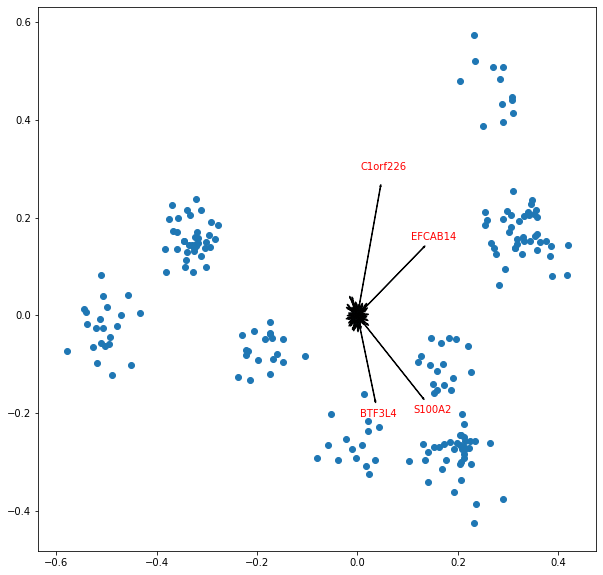

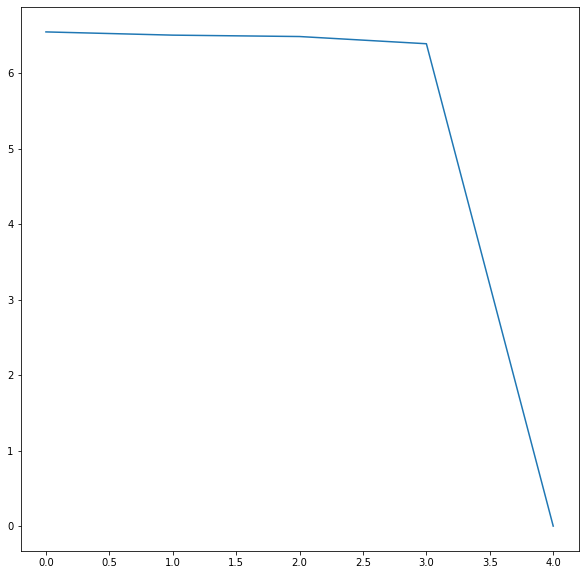

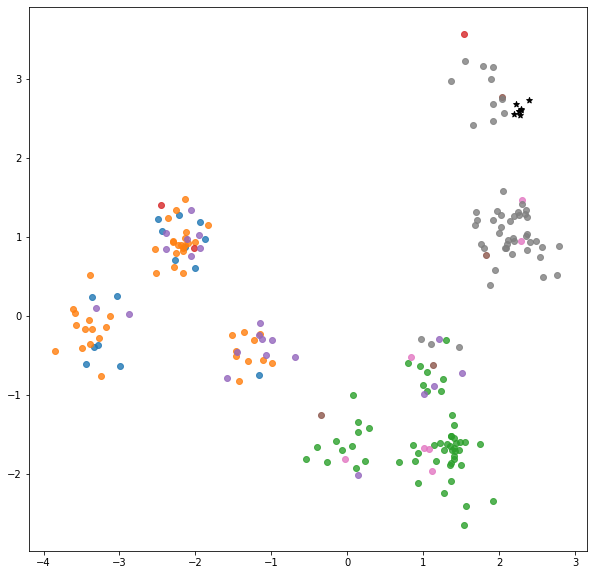

In [83]:
labels_list = list(data.head())
PCA_data, eig_vectors, eig_vals = PCA(log_data_arr, 8) 
PCA_plots(PCA_data, eig_vectors, eig_vals, labels_list)
plot_clusters(PCA_data, cluster_labels, centroids)
#TODO add the negative control data stuff

In [75]:
pca_centroids, pca_cluster_labels, pca_sqr_dist, test = hard_k_means_cluster(8, 
                                                                      np.asarray(PCA_data[:,0:2]), 15)

epoch
[0 1 2 3 4 5 6 7]
epoch
epoch
epoch
epoch
epoch
epoch
epoch
epoch
epoch
epoch
epoch
epoch
epoch
epoch


In [76]:
print(np.unique(pca_cluster_labels))

[0 1 2 3 4 5 6 7]


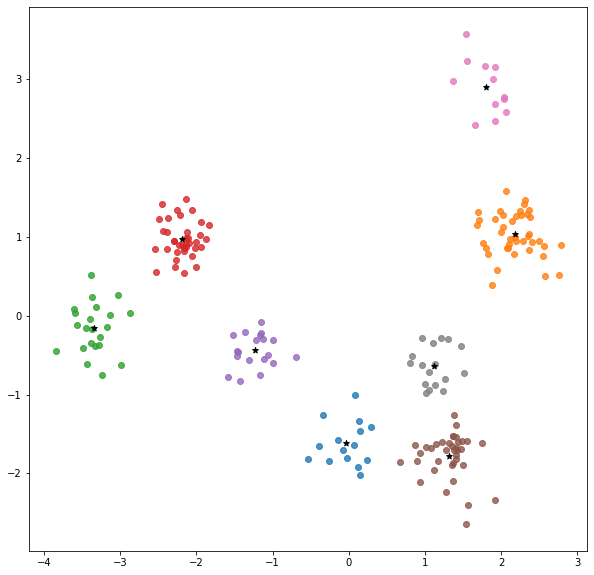

In [77]:
# These clusters are correct sometimes but inconsistent, even with many clustering trials. It seems like what 
# is giving the smallest distance is not correct. Also sometimes the centorids look correct but the clusters do
# not
plot_clusters(PCA_data[:,0:2], pca_cluster_labels, pca_centroids)


In [78]:
pca_sqr_dist

24.626089663049875

In [79]:
test

[24.626089663049875,
 55.87360761173112,
 41.90956777272509,
 24.626089663049882,
 41.38468723799657,
 39.07718397841962]

In [12]:
X_star = log_data_arr - np.mean(log_data_arr, axis=0)
U,S,V_T = svd(X_star)
U.shape

(200, 200)

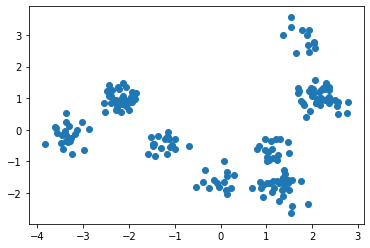

In [13]:
pca = np.matmul(X_star,np.transpose(V_T[0:2,:]))
plt.scatter(pca[:,0], pca[:,1])

__for part three, can fix by either de-noising the data with PCA before clustering or just clustering on the PCA components__

In [14]:
test = distance.euclidean([1,2,3], [4,5,6])
test_2 = np.sqrt((1-4)**2+(2-5))